{[Click aquí para leer este notebook en Google Colab](https://colab.research.google.com/drive/1ArhjRUCf_Qz3mZiwEzYR_BW5SoSSYHnL)}

<head><link rel = "stylesheet" href = "https://drive.google.com/uc?id=1zYOH-_Mb9jOjRbQmghdhsmZ2g6xAwakk"></head>

<table class = "header"><tr>
    <th align = "left">4AMBOT | Fase de desarrollo</th>
    <th align = "right">Escrito por: Gaston Solari Loudet</th>
</tr></table>

## <center><b><u>Formulación de estrategia</u></b></center>

La idea de este notebook es de formular la estrategia de Agustin Dragui tanto en palabras como en código, de manera de poder tener un modelo de prueba para trabajar, testear, y mas adelante automatizar para su uso en MetaTrader. Si bien la sintaxis de Python es algo mas simplista y contiene muchas herramientas esquemáticas (ej.: dataframes) y matemáticas (ej.: interpolaciones) que no tenemos en MQL, la mayoría de dichas cosas son programables o descargables en internet.

Las bibliotecas de funciones que vamos a necesitar, son las siguientes:
<ul><li>"<code>datetime</code>": Datos fecha/hora y manejo del tiempo.
</li><li>"<code>pandas</code>" y "<code>numpy</code>": Visualización de datos tabulados y herramientas matemáticas varias.
</li><li>"<code>matplotlib</code>": Gráficos. De todos modos usaremos 2 objetos específicamente programados para esto: "<code>GMAData</code>" y "<code>GMAPlot</code>".<br>Se descargan con "<code>requests</code>" desde GitHub. No se lo puede hacer desde Google Drive por sus actuales bloqueos de seguridad.</li></ul>

In [1]:
import pandas, numpy, datetime, matplotlib, matplotlib.pyplot, requests, datetime
Git, File = "https://raw.githubusercontent.com/gsolaril/4AMBOT/main/", "tools.py"
REQ = requests.get(Git + File, allow_redirects = True)
open("./tools.py", "wb").write(REQ.content)
GDrive = "https://drive.google.com/uc?id="
ID = "1TawPXELPzNlySaOx3HT67A-wHwRxuWjQ"
matplotlib.pyplot.style.use(GDrive + ID) ## Plot template.
from IPython.display import display
from tools import GMAData, GMAPlot

### <center><u><b>Búsqueda de reversals</b></u></center>

Como se ha visto y describiremos en detalles mas adelante, el método se basa fuertemente en un movimiento contratendencial que se da casualmente durante la vela de las 4 AM (UTC -3). Se lo puede observar como un rebote, un pullback o una simple mecha de rechazo. Como sea, nos interesa tener una herramienta para detectar este tipo de reacciones. 

En principio, debería ser una herramienta con un enfoque 100% geométrico. Es decir: debería funcionar para una secuencia continua de puntos cualesquiera, que no necesariamente sean de mercado. Por ello, nos centraremos en programarla y probarla para datos generados de forma aleatoria. Debería funcionar exactamente igual que con datos de mercado.

#### <u><b>Generador de datos aleatorios</b></u>

La forma mas facil de hacerlo, es simulando una "[Random Walk](https://en.wikipedia.org/wiki/Random_walk)". Es decir: que para un punto "$t$" de valor "$p(t)$", el punto que le sigue "$t + 1$" tenga un valor "$p(t + 1) = p(t) + \Delta p \times R$" adonde aquella "$R$" es un salto aleatorio de distribución de probabilidad normal, con media 0 y distribución estandar 1. En tal caso, aquel "\Delta p" es "cuanto queremos que ambos precios sucesivos difieran comúnmente uno de otro": lo que en general llamamos "<u>volatilidad</u>". ("``p_delta``")

Con "``numpy.random.randn``" generamos una sucesión de valores "$R$" aleatorios. Luego, calculamos su suma cumulativa ("``cumsum``") ya que lo que genera una Random Walk es la suma progresiva de dichos saltos: "$p(t) = p(0) + \Delta p \;\Sigma R_i$". Aquel "$p(0)$" es el valor del cual partimos. ("``p_start``")

Vamos a establecer algunas pautas:
* Con esos puntos vamos a armar velas japonesas. Vamos a usar 10 puntos para cada una.
* Con esas velas, vamos a armar "grupos" de velas adonde vamos a aplicar esa herramienta. Cada grupo va a contener "$n_V$" velas.
* Vamos a tener una cantidad total de "$n_G$" grupos, para poder comparar entre varios patrones de reversión, uno al lado del otro.

En el gráfico, el eje horizontal enumera a las velas de la forma "**01, XX:YY**" adonde "**XX**" es el número de grupo, mientras que "**YY**" es el número de vela dentro del grupo. Las lineas verticales separan a cada grupo. Observar como al aumentar la volatilidad "``p_delta``", si bien las velas no crecen visualmente de tamaño, los valores del eje vertical si lo hacen. Esto tendrá importancia a futuro.

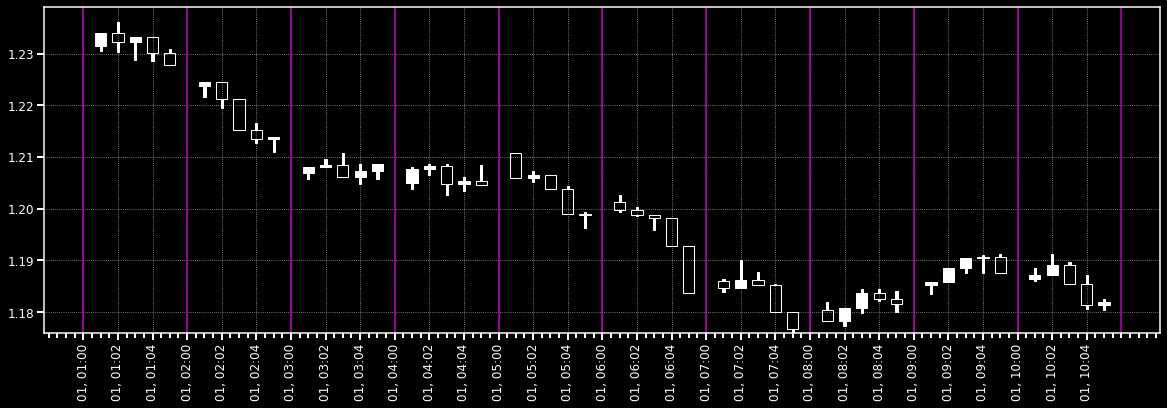

In [2]:
p_start = 1.2345  ;   nV = 5
p_delta = 0.001   ;  nG = 10
##########################
dates = datetime.datetime(2025, 10, 1)
R = numpy.random.randn(10*(nV + 1)*nG).cumsum()
R = (p_start + p_delta*R).round(5).reshape(-1, 10)
O, H, L = R[:, 0], R.max(1), R.min(1)
C = numpy.append(O[1:], R[-1, -1])
minute = datetime.timedelta(minutes = 1)
dates += numpy.arange(nV + 1)*minute
hour = datetime.timedelta(hours = 1)
times = numpy.arange(0, nG, 1/(nV + 1)).astype(int)
times = numpy.tile(dates, nG) + (1 + times)*hour
data = {"O": O, "H": H, "L": L, "C": C}
data = pandas.DataFrame(data, index = times)
data.iloc[:: nV + 1] = None
Figure1, Axes1 = GMAPlot.candle_plot(data)
Axes1.tick_params(labelsize = 12)
for group in range(nG + 1):
    Axes1.axvline(x = (nV + 1)*group, color = "m")

#### <u><b>Función de intensidad de rebote</b></u>

El objetivo fundamental es el de encontrar cierta función matemática que tome a los "$n_V$" valores de las velas, y devuelva un número que dé una idea de "la intensidad del rebote". Que sea...
* ...positivo cuando la reacción es de abajo hacia arriba.
* ...negativo cuando la reacción es de arriba hacia abajo.
* ...casi cero cuando se mantiene una tendencia.
* ...casi cero cuando el mercado se mueve de manera horizontal.

Durante estas últimas semanas, se investigaron varias variantes. La mayoría tienen que ver con la relación de tamaño entre mechas de velas y cuerpos. A continuación, algunos borradores:

<center><img src = "https://drive.google.com/uc?id=12U2i9Q73UIRDLQzJrtXLb6JMRn38DO2_" width = "75%%"></img></center>

Una opción tentativa es la de usar regresiones a través de cada bloque. Como las reversiones no son geometrías lineales ya que necesitamos una derivada segunda, como mínimo tenemos que usar una aproximación cuadrática y sus respectivas derivadas:
* "$f(t) = a_0 + a_1 t + a_2 t^2$".
* "$f'(t) = a_1 + 2 a_2 t$".
* "$f''(t) = 2 a_2$".

Justamente, a la derivada segunda "$f''(t)$" a veces se la suele llamar "curvatura" ("$K$"). Cuanto mas chica es, mas "recta" es la curva. Al mismo tiempo: la curva dibuja una $\cup$ si "$K$" es positiva, o una $\cap$ en caso contrario.

#### <u><b>Regresiones</b></u>

A la hora de hacer una regresión, no nos sirve tener "velas". Necesitamos puntos: debemos elegir cuales "<u>puntos característicos</u>" tomar de las velas. Podríamos usar los valores de cierre ("``Close``") pero aquellos no contemplan los extremos a los cuales llegaron los precios, y aquello es precisamente lo que necesitamos. Por lo tanto lo que hacemos es tomar el <u>promedio</u> de los "``High``" y los "``Low``". Recordar que nuestros datos "``ohlc``" son un ``dataframe`` con lo cual podemos asignarles un vector de pesos ("``[O, H, L, C] = [0, 1/2, 0, 1/2]``") mediante un producto escalar ("``dot``") por cada vela.

La función "``numpy.polyfit``" me devuelve un vector ("``poly``") con los coeficientes del polinomio regresor: "$(a_0, a_1, a_2,..., a_n)$". De manera facil, se pueden obtener los vectores de las derivadas ("``d1_x``" y "``d2_x``") con la función "``numpy.polyder``". Hay que evaluar el valor ("``d1_v``" y "``d2_v``") de cada uno de estos polinómios en la sucesión de puntos característicos (promedios High-Low). Una vez hecho esto, podemos incluso ya dibujar las curvas aproximadoras sobre los grupos de velas.

<u>Como nos damos cuenta de si existe una reversión</u>? La condición mas importante es que si hay un máximo/mínimo en el polinomio, que este se ubique **dentro** de la curva. Eso quiere decir: en las velas centrales y no en las que estan en los límites de cada grupo. No podemos tomar un grupo de velas de tamaño "$n_V$" infinito: sino, el análisis sería demasiado impreciso (nos estaríamos alejando demasiado de las 4 AM). Al limitarnos a un "$n_V$" menor, inevitablemente estamos dejando velas afuera hacia ambos lados del grupo.

<center><img src = "https://drive.google.com/uc?id=1CUjWzAPpVZwe7Mmx1wayGUXVHRj9EbW8" width = "35%"></img></center>

Pero por ejemplo: Supongamos que, como indica la figura de arriba, hallamos un mínimo en la primera {o última} vela del grupo. Si no tenemos en cuenta aquello que pasa en las velas de mas allá a la izquierda {o derecha} ¿Como podemos saber que es un mínimo de verdad? En ese caso, es mejor descartarlos y suponer que no lo son. Al centrarnos en los máximos y mínimos observables en el centro de un grupo ("$0 < t < n_V - 1$"), ubicar reversiones es mas facil y mas seguro. En términos matemáticos, los máximos/mínimos son aquellos puntos adonde la derivada primera ("``d1_v``") es cero. O en este caso, adonde el valor absoluto ("``abs``") es el menor posible ("``numpy.argmin``").

In [3]:
%%capture
degree = 2 ## Grado de polinomio.
Blocks = list()
Axes1.grid(False)
ymin, ymax = Axes1.get_ylim()
yd = ymax - ymin
for group in range(1, len(data) + 1, nV + 1):
    t = range(group, group + nV)
    ohlc = data.iloc[t, :]
    ohlc.loc[:, "T"] = ohlc.dot([0, 1, 0, 1])/2
    display(ohlc)
    poly = numpy.polyfit(t, ohlc.loc[:, "T"], degree)
    print("Group %d: converged" % group)
    ohlc.loc[:, "P"] = numpy.polyval(poly, t)
    d1_x = numpy.polyder(poly, m = 1)
    d2_x = numpy.polyder(poly, m = 2)
    d1_v = numpy.polyval(d1_x, t)
    d2_v = numpy.polyval(d2_x, t)
    x_d0 = numpy.abs(d1_v).argmin()
    is_rev = (0 < x_d0 < nV - 1)
    curv, line = d2_v[x_d0], None
    if (is_rev and curv > 0): line = ohlc["L"].min()
    if (is_rev and curv < 0): line = ohlc["H"].max()
    Axes1.plot(t, ohlc["P"], "r", lw = 3)
    Blocks.append({"ohlc": ohlc, "line": line, "curv": curv})
    if not is_rev: continue
    x, y = [t[0], t[-1]], [line, line]
    Axes1.axhline(y = line, ls = ":", color = "y")
    Axes1.plot(x, y, ls = "-", color = "y", lw = 2)
    Axes1.text(t[0], ymin - yd/15, "K = %.4f" % curv, fontsize = 12)

¿<u>Podemos usar "$K$" como nuestro número de intensidad de rebote</u>? En realidad, no del todo. Si bien cumple con las condiciones enlistadas mas arriba, dicho número no contempla el tema de la volatilidad. Podemos tener un "$K$" muy alto, y aun así no ser muy significativo por estar en un periodo de consolidación muy volatil. O en caso contrario, podemos tener un "$K$" bajo y significar una reversión ante una tendencia leve pero sostenida. Si bien no es necesario para continuar, sería bueno mejorar este algoritmo agregando algún factor de normalización que incluya a la volatilidad como variable.

Otro tema: ¿<u>Debería usarse un grado de polinomio mas alto que 2</u>? Hay que tener cuidado con esto. Por teorema fundamental del álgebra, no se puede interpolar una secuencia de "$n_V$" puntos con un grado mayor a "$n_V$". El usar un grado mas alto, hace que el polinomio sea mas preciso. Pero lo bueno de usar "``degree = 2``" es que aseguramos que solo se contemple un único máximo/mínimo en todo el grupo. De otro modo, corremos el riesgo de tener una curva aproximadora con forma de "N" o "M" en lugar de la "U" que buscamos.

Las curvas rojas en la figura siguiente, son las curvas interpoladoras de los polinomios. Aquellos máximos/mínimos que fueron validados como reversiones, se ven como trazos amarillos. Debajo de cada patrón de reversión, se ve el valor de la curvatura "$K$" (derivada segunda). 

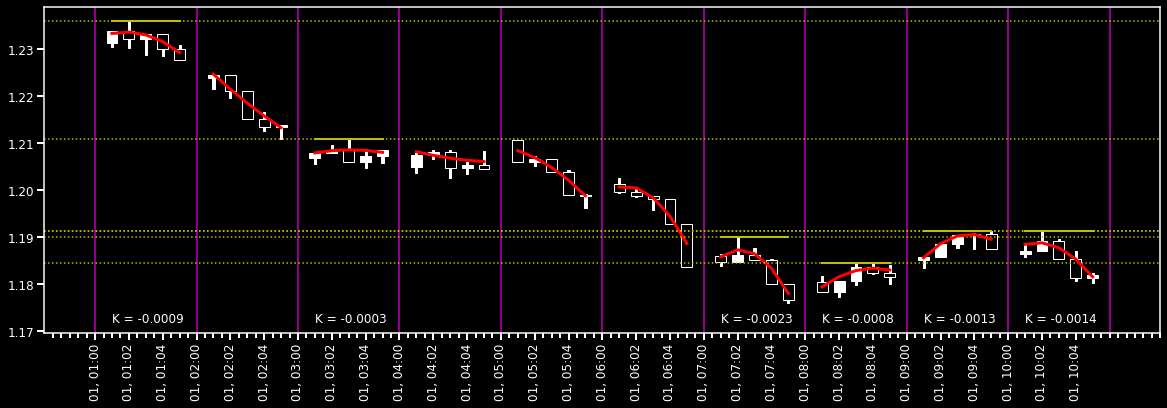

In [4]:
Axes1.set_ylim(ymax = ymax, ymin = ymin - yd/10)
Axes1.figure

### <center><b><u>Búsqueda de lineas de soporte y resistencia</u></b></center>

Las lineas de soporte y resistencia (S&R) son parte de las varias teorías "polémicas" que contemplan al mercado como un sistema parcialmente determinista. Se creen que los fenómenos que la causan, son certeros y predecibles: no aleatorios. Por eso, como se oponen a la "[hipótesis del mercado eficiente](https://en.wikipedia.org/wiki/Efficient-market_hypothesis)", estaría mal usar datos generados de manera aleatoria. Necesitamos datos reales de mercado para suponer su existencia.

#### <b><u>Descarga de datos mediante [Finnhub.io](https://finnhub.io/docs/api/forex-candles)</u><b>

Comúnmente, hemos usado siempre a [Yahoo Finance](https://github.com/ranaroussi/yfinance) y archivos CSV como fuentes de historial de mercado. Sin embargo, necesitamos algo que:
* Tenga un horizonte de datos de mas de un mes.
* No tenga periodos de cierre de mercado (excepto fines de semana)
* No tenga limitaciones de descarga (request) demasiado estrechas.
* Tenga datos de un broker del cual se conozca su zona horaria (ej.: [OANDA](https://www.oanda.com/bvi-es/), UTC 0).

<u>Nota</u>: los datos descargados de Finnhub vienen con marcas temporales en formato Unix.
<br>Se suma la diferencia horaria en segundos ("$d_{UTC} \;[hs] \times 60 \;min/h \times 60 \;seg/min$").
<br>El eje horizontal de la gráfica, muestra las marcas temporales como "DD, HH:MM".

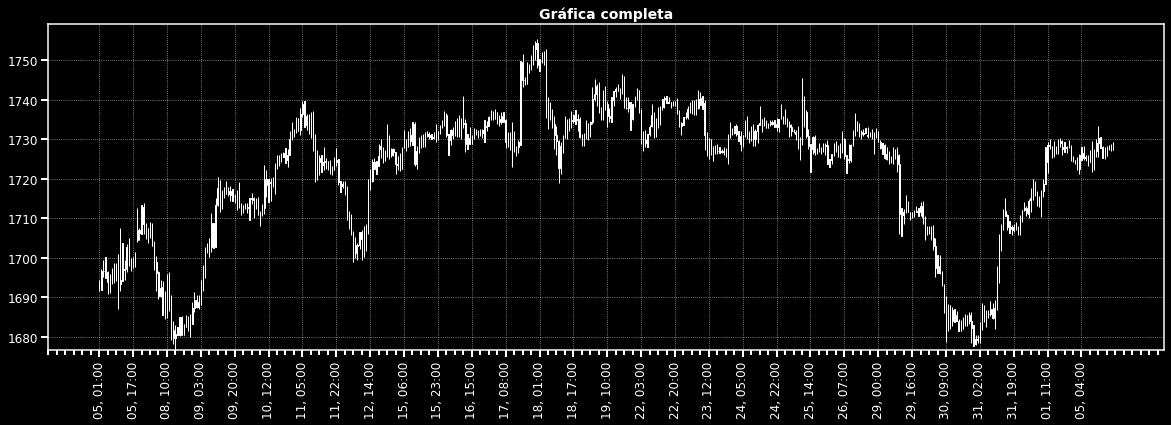

In [5]:
import finnhub
FCL = finnhub.Client(api_key = "c1cjh0748v6vbcpf2rlg")
days = 120 ; d_UTC = -3  # Se banca hasta 2000 velas.
#####################################################
t = datetime.datetime.now()
t = int(t.timestamp())
t0 = t - days*24*60*60

Data = FCL.forex_candles("OANDA:XAU_USD", 60, t0, t)
Data.pop("s")    ;    Data = pandas.DataFrame(Data)
Data["t"] = Data["t"] + d_UTC*60*60
Data.set_index("t", inplace = True)
Data.index = pandas.to_datetime(Data.index, unit = "s")
Data.columns = [_.upper() for _ in Data.columns]
Figure2, Axes2 = GMAPlot.candle_plot(Data[-480:]) ## Gráfica de velas.
Axes2.set_title("Gráfica completa", fontsize = 14, fontweight = "bold");

#### <b><u>Uso de canales de máximos/mínimos móviles</u></b>

Si bien nuestro uso de las lineas S&R dentro de esta estrategia será similar al de los reversals, contemplamos a su origen y naturaleza como algo diferente. En el caso de los reversals, buscamos areas de reacción en momentos puntuales del día que nosotros definimos (mas especificamente, cerca de las AM). En el caso de las lineas S&R, no nos importa el momento del día en el cual son tocadas, sino la cantidad de veces que sucede. Es la incidencia de ellas en todo momento del día, lo que nos importa.

No conviene usar regresiones polinómicas como en el caso anterior, porque tendríamos que tomar demasiados grupos de velas. Y en esos grupos de velas, el tamaño debería ser variado para filtrar que las lineas mas importantes prevalezcan sobre las menos incidentes. De modo que lo que haremos entonces, será mas simple: buscar máximos y mínimos a través de toda una amplia gama de velas pasadas, quedandonos con aquellos valores que se concentran en un area densa.

Así como comúnmente usamos médias móviles ("``rolling``") en trading, existen también los ``máx``imos/``mín``imos móviles; que toman una ventana de velas de un cierto ``period``o, y se quedan con el "High" ("``H``") mas alto y el "Low" ("``L``") mas bajo. Normalmente se los conoce como "canales de [Donchian](https://en.wikipedia.org/wiki/Donchian_channel)". Para mejor visualización, graficamos solo las últimas 100-200 velas con sus respectivos canales en azul. 

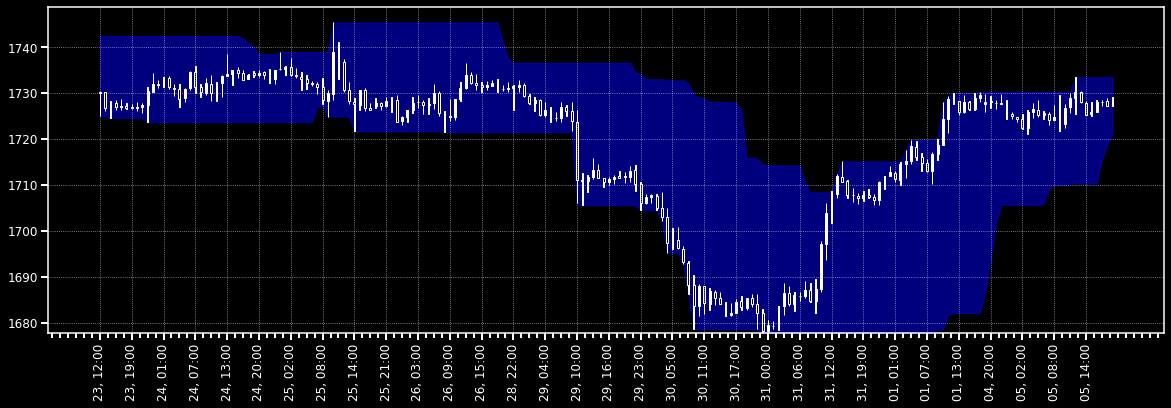

In [6]:
period = 32
candles = 192
Data["Don.max"] = Data.loc[:, "H"].rolling(period).max()
Data["Don.min"] = Data.loc[:, "L"].rolling(period).min()
Data_reduced = Data.copy()[-candles :]
Figure3, Axes3 = GMAPlot.candle_plot(Data_reduced)
Axes3.fill_between(range(len(Data_reduced)), Data_reduced["Don.max"],
    Data_reduced["Don.min"], color = "blue", zorder = -10, alpha = 0.5);

#### <b><u>Lineas S&R como valores recurrentes</u></b>

Conceptualmente, es como si los canales Donchian dibujasen segmentos de S&R a corto plazo en la gráfica. Pero "uniendo" segmentos a una altura similar, podríamos obtener una linea de S&R. Es decir: si en la gráfica aquí arriba ubico una "regla" sobre la pantalla a lo largo de un techo o piso azul, y veo que hay otra linea de ellas que coincide, puedo resaltada como una linea. Si el segmento es mas largo, o si hay varios segmentos alrededor de una misma altura, entonces esa linea debería ser mas "resaltada".

Ese es el criterio que utilizaremos. Análogo a ello, es igual que contar la cantidad de veces que cada valor de los canales Donchian aparecen dentro del dataframe descargado desde Finnhub. Pero para tener en cuenta la incidencia de cada linea en areas tanto locales como globales, necesitamos una gama extensa de ``period``os de Donchian.

Tener en cuenta que con los canales Donchian, tenemos el mismo inconveniente inicial que con cualquier indicador móvil ("``rolling``") de análisis técnico: para un periodo "$P$", recién voy a tener el primer cálculo válido de indicador pasadas las primeras "$P$" velas. Previo a eso, tendré solo valores indeterminados ("``NaN``"). Si quiero tener la mayor cantidad de valores de Donchian precisos para un dataframe con "$N$" velas, el periodo mas grande que voy a poder usar, evitando quedarme sin datos, será de "$N/2$" ([criterio de Nyquist](https://en.wikipedia.org/wiki/Nyquist_rate)).

La evidencia de esto está en que al ver la siguiente grilla de valores de Donchian vs. tiempo y periodo, los NaN empiezan a desaparecer hacia la mitad, yendo desde arriba hacia abajo.

In [19]:
Donchian = pandas.DataFrame()
period_final = len(Data_reduced)//3
period_start = 2
for period in range(period_start, period_final + 1, 2):
    Donchian[f"MAX_{period}"] = Data_reduced["H"].rolling(period).max()
    Donchian[f"MIN_{period}"] = Data_reduced["L"].rolling(period).min()
Donchian.index = [x.strftime(format = "%m/%d %H:%M") for x in Donchian.index]
Weights = pandas.Series(1 + numpy.arange(len(Donchian)),
          index = Donchian.index).apply(func = lambda x: x)
## Poner un dec. menos que estandar de instrumento. ej.: EURUSD = 5 - 1 = 4
Donchian = Donchian.round(4)
Donchian

,MAX_2,MIN_2,MAX_4,MIN_4,MAX_6,MIN_6,MAX_8,MIN_8,MAX_10,MIN_10,...,MAX_56,MIN_56,MAX_58,MIN_58,MAX_60,MIN_60,MAX_62,MIN_62,MAX_64,MIN_64
03/23 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/23 13:00,1730.318,1724.917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/23 14:00,1730.184,1724.597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/23 15:00,1728.436,1724.597,1730.318,1724.597,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/23 16:00,1728.686,1726.285,1730.184,1724.597,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
04/05 15:00,1728.375,1724.952,1733.460,1724.952,1733.460,1722.287,1733.46,1721.779,1733.46,1721.779,...,1733.46,1682.118,1733.46,1682.118,1733.46,1678.484,1733.46,1677.855,1733.46,1677.788
04/05 16:00,1728.404,1724.952,1730.545,1724.952,1733.460,1724.952,1733.46,1721.779,1733.46,1721.779,...,1733.46,1682.118,1733.46,1682.118,1733.46,1681.713,1733.46,1678.484,1733.46,1677.788
04/05 17:00,1728.524,1725.793,1728.524,1724.952,1733.460,1724.952,1733.46,1722.287,1733.46,1721.779,...,1733.46,1682.118,1733.46,1682.118,1733.46,1682.118,1733.46,1678.484,1733.46,1677.855
04/05 19:00,1728.893,1727.097,1728.893,1724.952,1730.545,1724.952,1733.46,1724.952,1733.46,1721.779,...,1733.46,1682.118,1733.46,1682.118,1733.46,1682.118,1733.46,1681.713,1733.46,1678.484


Como ya vimos, a mas cantidad de velas ($N$), **(1)** mas valores de Donchian ($N/2$), pero **(2)** mas periodos también ($N/2$) si es que tomamos todos los posibles. Por ello, se puede decir que el algoritmo tiene <u>complejidad cuadrática</u>: "$O(N^2/4)$". Precisamente, "$N^2/4$" es el area del triangulo ocupado por números no-NaN en la grilla de arriba: de altura "$N$" y ancho "$N/2$" (periodos).

Despues de eliminar todas las filas con "``NaN``s" ("``dropna``"), Comenzamos un conteo (``value_counts``) de la cantidad de veces que cada mismo número aparece. Vamos así, armando una lista de valores recurrentes. Los que mas veces aparecen, son las lineas S&R mas fuertes. Pero notar que dado que a la grilla la debemos re-transitar en sus "N^2/4" valores para este conteo, la complejidad del algoritmo se duplica: "$O(N^2/2)$"

Esto puede ser peligroso ya que puede tomar demasiado tiempo/memoria en un sistema de trading automático. Pero afortunadamente, la estrategia es intradía, con 24 hs entre trade y trade según convenido. Y tampoco es que tenemos que estar buscando lineas de S&R todo el día, todo el tiempo. Podemos hacer un análisis exhaustivo (1000 velas en H1) una vez al día, y otro mas reciente (48 velas) cerca de las 4 AM. Como es cuestión de contar incidencias, ambos análisis son independientes y mutuamente complementarios. Se deja para un futuro, buscar la manera de reducir la complejidad computacional de este método.

Agregamos un número de filtro "$pc_{min}$": Si la linea mas importante aparece en "$f_{max}$" ocasiones, toda aquella linea que aparezca menos de "$pc_{min} \times f_{max}$" veces, se descarta. Por ejemplo: Si la linea mas fuerte apareció 1000 veces y usamos un filtro del 10%, pondremos en la lista a todas las lineas que aparecen mas de 100 veces.

In [20]:
pc_min = 0.1 ## <== filtro de lineas
print("Dimensiones de grilla, antes: %s" % (Donchian.shape,))
Donchian = Donchian.dropna()
print("Dimensiones de grilla, despues: %s" % (Donchian.shape,))
ArrayDonchian = numpy.squeeze(Donchian.values.reshape([-1, 1]))
### De la grilla al conteo: eliminación de la linea de tiempo.
Table = pandas.value_counts(ArrayDonchian).to_frame().reset_index()
Table.rename(columns = {"index": "Lines", 0: "Count"}, inplace = True)
fmax = Table.loc[:, "Count"].max()
Table = Table[Table.iloc[:, -1] > pc_min*fmax].transpose()
Table.loc["Count", :] = Table.loc["Count", :].astype(dtype = int)
Table

Dimensiones de grilla, antes: (192, 64)
Dimensiones de grilla, despues: (129, 64)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Lines,1677.788,1721.514,1736.611,1745.404,1730.282,1678.607,1705.598,1715.126,1733.46,1705.678,1682.118,1719.876,1714.275,1721.181,1730.002,1732.779,1732.998,1728.087
Count,1056.000,656.000,615.000,529.000,504.000,354.000,327.000,282.000,244.00,184.000,171.000,155.000,136.000,136.000,126.000,126.000,126.000,126.000


#### <b><u>Futuras mejoras</u></b>

A continuación simplemente graficaremos la lista filtrada de lineas resultantes. El grosor del trazo es proporcional a la incidencia: Aquella que mas veces aparece, será mas gruesa.

El método elegido es simple y conciso. Se basa en conceptos 100% básicos y lógicos. De todos modos, se basa en "fuerza bruta", lo cual puede hacerlo algo impreciso e ineficiente. Una cuestión pendiente de atacar, es en el hecho de que las lineas S&R no son lineas sino areas: no son un precio único, sino un rango estrecho.

Se debe buscar la forma de "unificar" aquellas lineas muy cercanas unas de otras, para evitar tener una lista demasiado grande y sin sentido. Mas adelante se verá que por lo general, estas lineas son usadas como "inhibidoras" de trades: se supone que demasiada cercanía a ellas puede disminuir la probabilidad de reversión a las 4 AM. El exceso de lineas puede inhabilitar al sistema de ejecutar trades en areas adonde sí podría hacerlo. Es no mas que simplemente mejorar el método de filtrado.

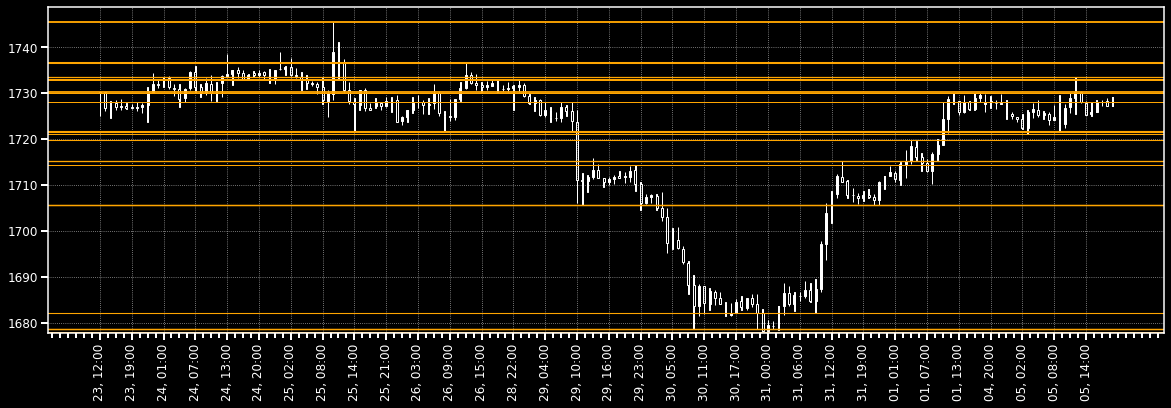

In [21]:
Figure4, Axes4 = GMAPlot.candle_plot(Data_reduced)
fmin = Table.loc["Count", :].min()
wmin, wmax = 1, 3 ## Grosor de trazo mínimo y máximo.
## FUnción grosor proporcional a que tan frecuente es el valor:
width = lambda x: wmin + (wmax - wmin)*(x - fmin)/(fmax - fmin)
for n in range(len(Table.columns)):
    line, freq = Table.loc[["Lines", "Count"], n]
    Axes4.axhline(y = line, lw = width(freq), color = "orange")

### <center><b><u>Estrategia predictiva</u></b></center>

Ya teniendo las dos herramientas fundamentales para anticipar la contratendencia, pasaremos a formular la forma en la cual decidimos como y cuando considerar una posible señal de entrada. Para este instante, tengo que tener ya una lista completa de lineas de reversión ("``REV``") y de soporte & resistencia ("``SNR``"). Como en todo momento necesitamos saber cuales son las lineas mas cercanas al precio actual, lo ideal es que  estas listas estén ya ordenadas de menor a mayor. También deben irse actualizando periodicamente al paso del tiempo.

#### <b><u>Condiciones de ejecución</u></b>

Esta primera parte depende mas que nada de la presencia de una linea de reversión cercana. En la forma mas simple:
* **Compro** ("``order = +1``") si la vela que se encuentra formandose, toca una línea de reversión **desde arriba hacia abajo**.
* **Vendo** ("``order = -1``") si la vela que se encuentra formandose, toca una línea de reversión **desde abajo hacia arriba**.

#### <b><u>Condiciones de validación</u></b>